# Word2Vect CBOW with Tensorflow

The goal is to create a space of vector embeddings for a set of words (our vocabulary) that holds some semantic logic.  
For instance, distance and addition operations of vectors should make sense semantically such as:  
king - man = queen - woman or put differently king = queen - woman + man.

In [1]:
import gensim.downloader as api

In [2]:
dataset = api.load("text8")

In [3]:
# Let's visualize our data
i = 0
for x in dataset:
  print(x)
  i += 1
  if i > 10:
    break

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

In [4]:
api.info("text8")

{'num_records': 1701,
 'record_format': 'list of str (tokens)',
 'file_size': 33182058,
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py',
 'license': 'not found',
 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.',
 'checksum': '68799af40b6bda07dfa47a32612e5364',
 'file_name': 'text8.gz',
 'read_more': ['http://mattmahoney.net/dc/textdata.html'],
 'parts': 1}

In [5]:
# build word2idx
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

In [7]:
print('Number of documents: ', len(sequences)) ## nbr of documents
print('Number of tokens in our first document: ',len(sequences[0])) ## nbr of tokens in our first document

Number of documents:  1701
Number of tokens in our first document:  9538


TF tokenizer has useful word2index and index2word dictionaries.

In [8]:
print(tokenizer.index_word[sequences[0][0]])
print(tokenizer.word_index['queen'])

anarchism
903


### Now let's build word2vect!

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model

# set our random seeds
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# build model

# HyperParams (exercise: try other hyperparameters)
context_size = 10 # this means that we will look at 5 words before and five words after the word we are trying to predict
embedding_dim = 50 # this is the dimension of the embedded vectors.
alpha = 0.001 # learning_rate
batch_size = 128
nbr_epochs = 8000

model = tf.keras.Sequential([
    Input(shape=(context_size,)), # we take context_size tokens as input
    Embedding(vocab_size, embedding_dim), # we create an embedding matrix of shape vocabulary_size x context_size x emdedding_dimension
    Lambda(lambda t: tf.reduce_mean(t, axis=1)), # we take the mean of the context vectors, so now we have a matrix of shape vocabulary_size x embedding_size
    Dense(vocab_size, use_bias=False) # the last layer is of vocabulary_size and should predict the word in the middle of the context words.
])
model.summary()

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 50)            1000000   
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20000)             1000000   
                                                                 
Total params: 2000000 (7.63 MB)
Trainable params: 2000000 (7.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This next piece of code arrange our dataset into context windows and corresponding word labels

In [11]:
half_context_size = context_size // 2

def data_generator(sequences, batch_size=128):
  X_batch = np.zeros((batch_size, context_size))
  Y_batch = np.zeros(batch_size)
  n_batches = int(np.ceil(len(sequences) / batch_size))
  while True:
    random.shuffle(sequences)

    # one epoch will be one pass through the data
    for i in range(n_batches):
      batch_sequences = sequences[i * batch_size : (i + 1) * batch_size]

      current_batch_size = len(batch_sequences) # may be less than batch_size
      for ii in range(current_batch_size):
        seq = batch_sequences[ii]
        j = np.random.randint(0, len(seq) - context_size - 1) # chose a random start of a context_size window
        x1 = seq[j : j + half_context_size] # create the after half context window
        x2 = seq[j + half_context_size + 1 : j + context_size + 1] # create the after half context window
        # x = x1 + x2
        # X_batch[ii] = x
        X_batch[ii, :half_context_size] = x1
        X_batch[ii, half_context_size:] = x2
        y = seq[j + half_context_size]
        Y_batch[ii] = y
      
      yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [12]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=alpha),
  metrics=['accuracy']
)

In [13]:
# takes about 25 min
r = model.fit(
  data_generator(sequences, batch_size),
  epochs=nbr_epochs,
  steps_per_epoch=int(np.ceil(len(sequences) / batch_size))
)

Epoch 1/8000
14/14 [==============================] - 0s 19ms/step - loss: 9.9032 - accuracy: 0.0100
Epoch 2/8000
14/14 [==============================] - 0s 14ms/step - loss: 9.9015 - accuracy: 0.0529
Epoch 3/8000
14/14 [==============================] - 0s 17ms/step - loss: 9.8955 - accuracy: 0.0770
Epoch 4/8000
14/14 [==============================] - 0s 9ms/step - loss: 9.8801 - accuracy: 0.0758
Epoch 5/8000
14/14 [==============================] - 0s 11ms/step - loss: 9.8440 - accuracy: 0.0776
Epoch 6/8000
14/14 [==============================] - 0s 10ms/step - loss: 9.7906 - accuracy: 0.0664
Epoch 7/8000
14/14 [==============================] - 0s 10ms/step - loss: 9.7026 - accuracy: 0.0764
Epoch 8/8000
14/14 [==============================] - 0s 8ms/step - loss: 9.5958 - accuracy: 0.0600
Epoch 9/8000
14/14 [==============================] - 0s 9ms/step - loss: 9.4420 - accuracy: 0.0764
Epoch 10/8000
14/14 [==============================] - 0s 9ms/step - loss: 9.2934 - accuracy: 

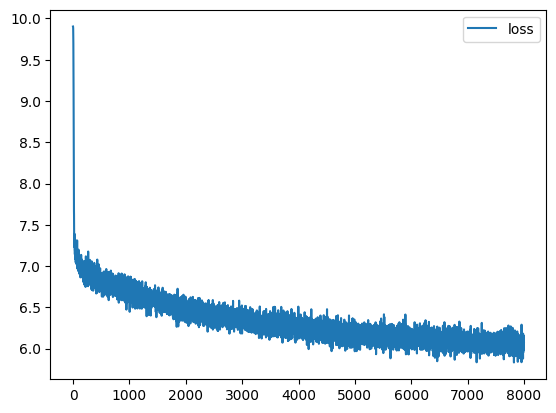

In [14]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.legend();

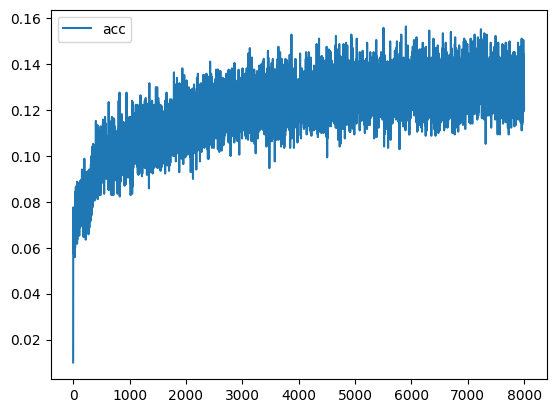

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.legend();

In [16]:
# Get embedding matrix
embeddings = model.layers[0].get_weights()[0]
embeddings.shape

(20000, 50)

In [17]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [18]:
def print_neighbors(query):
  query_idx = tokenizer.word_index[query]
  query = embeddings[query_idx:query_idx + 1]
  distances, indices = neighbors.kneighbors(query)
  for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

In [19]:
print_neighbors('paris')
print('\n')
print_neighbors('chess')


paris
vienna
berlin
florence
milan


chess
multiplayer
poker
arcade
rpg


In [20]:
# king - man = queen - woman

def get_embedding(word):
  idx = tokenizer.word_index[word]
  return embeddings[idx:idx + 1]

king = get_embedding('king')
man = get_embedding('man')
woman = get_embedding('woman')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

king
queen
pope
viii
prince
